In [3]:
import torch as t

import matplotlib.pyplot as plt

from concept_erasure import LeaceFitter, LeaceEraser

In [15]:
X = t.randn(5, 10)
sigma = X @ X.t()

L, V = t.linalg.eigh(sigma)

print(sigma @ t.einsum('ij,j,kj->ik', V, 1/L, V))

print(sigma @ t.cholesky_inverse(t.linalg.cholesky(sigma)))

tensor([[ 1.0000e+00,  9.2387e-07, -1.0431e-07,  2.9802e-08, -2.9802e-08],
        [ 5.3048e-06,  1.0000e+00, -3.8743e-07,  4.8280e-06, -7.7486e-07],
        [ 1.5050e-06,  6.6310e-07,  1.0000e+00,  1.0505e-06, -2.7567e-07],
        [-1.1995e-06, -5.8115e-07,  2.2165e-07,  1.0000e+00,  2.6822e-07],
        [ 2.1458e-06,  0.0000e+00, -2.0862e-07,  2.1458e-06,  1.0000e+00]])
tensor([[ 1.0000e+00,  0.0000e+00,  6.7055e-08,  4.4703e-07, -2.9802e-08],
        [ 2.4438e-06,  1.0000e+00, -2.2352e-07,  1.1921e-06, -1.1921e-07],
        [ 4.7684e-07,  1.8254e-07,  1.0000e+00,  2.4587e-07, -7.4506e-09],
        [ 2.0266e-06,  8.9407e-08, -5.9605e-08,  1.0000e+00, -8.9407e-08],
        [ 4.7684e-07,  1.1921e-07,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


In [8]:
def get_acts(behavior, layer):
    neg = t.load(f"../output/0229/activations/{behavior}/activations_neg_{layer}_Llama-2-7b-chat-hf.pt", map_location='cpu')
    pos = t.load(f"../output/0229/activations/{behavior}/activations_pos_{layer}_Llama-2-7b-chat-hf.pt", map_location='cpu')
    return pos, neg

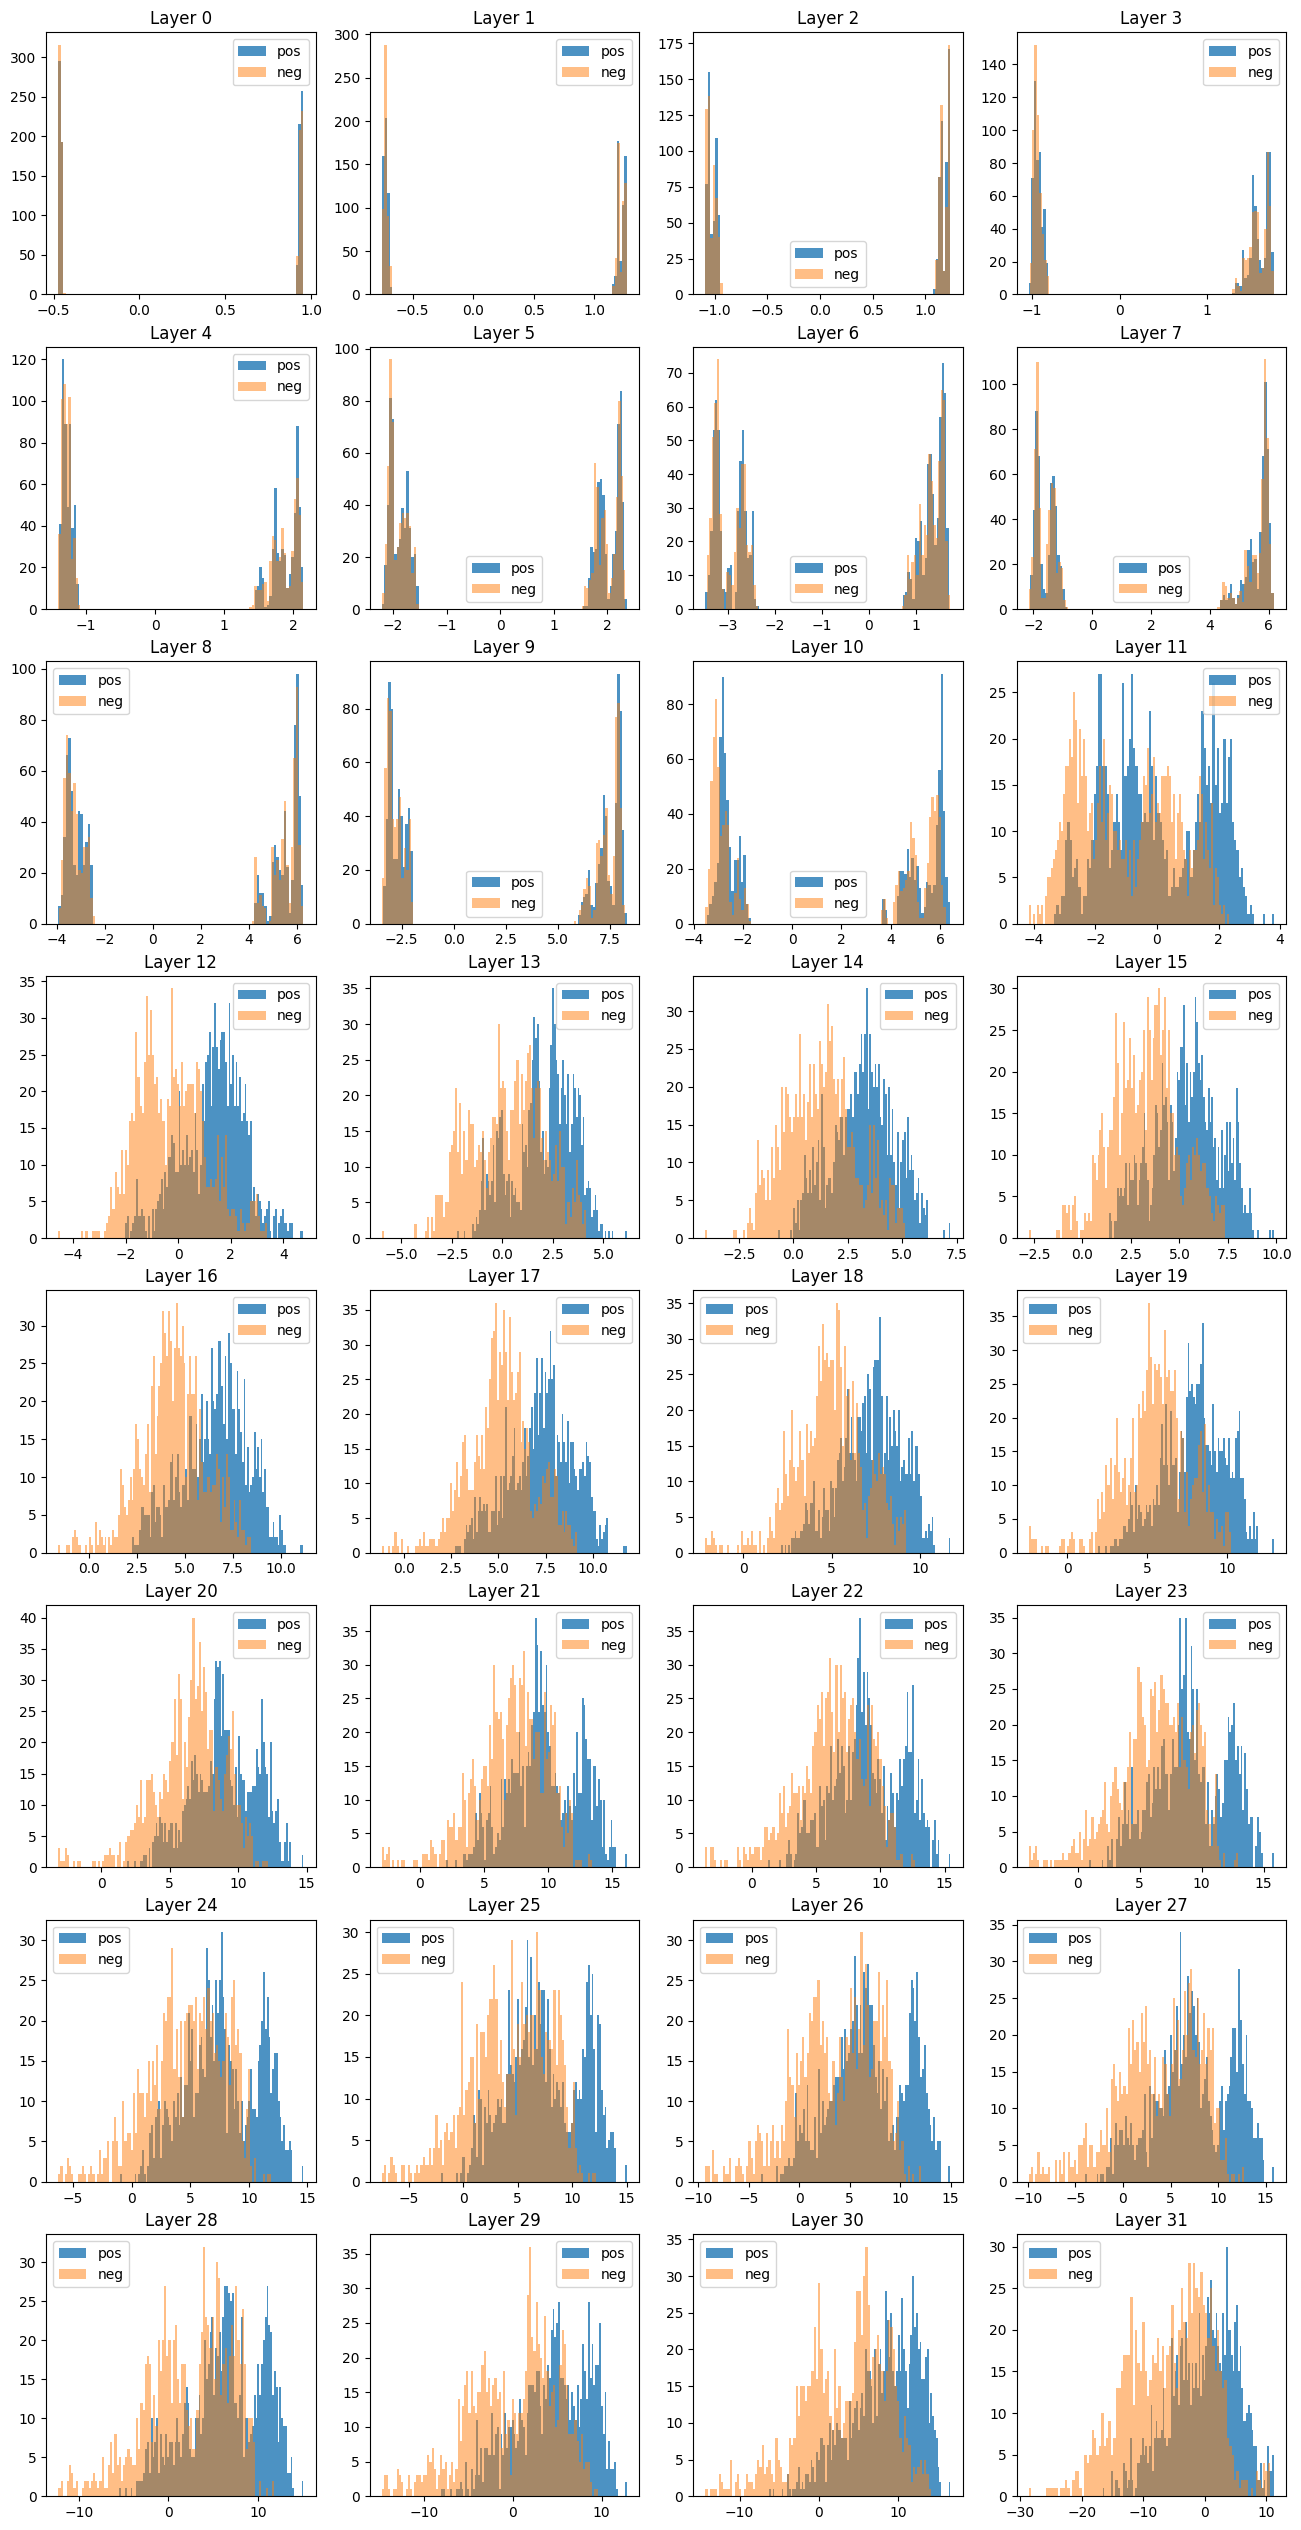

In [9]:

behavior = "sycophancy" 
# behavior = "coordinate-other-ais"

fig, axs = plt.subplots(8, 4, figsize=(16, 32))

for layer in range(32):
    pos, neg = get_acts(behavior, layer)
    
    vec = (pos-neg).mean(dim=0)
    u = vec/vec.norm()

    pos_vals = pos @ u
    neg_vals = neg @ u

    # plot pos and neg histograms with transparency
    axs[layer//4, layer%4].hist(pos_vals, bins=100, alpha=0.8, label="pos")
    axs[layer//4, layer%4].hist(neg_vals, bins=100, alpha=0.5, label="neg")
    axs[layer//4, layer%4].set_title(f"Layer {layer}")
    axs[layer//4, layer%4].legend()

In [10]:
def change_eraser_dtype(eraser : LeaceEraser, dtype):
    proj_left = eraser.proj_left.to(dtype)
    proj_right = eraser.proj_right.to(dtype)
    bias = eraser.bias.to(dtype)
    return LeaceEraser(proj_left, proj_right, bias)

In [11]:
behavior = "sycophancy"

layers = range(32)

fitters : dict[int, LeaceFitter] = {l: None for l in layers}

for l in layers:
    pos, neg = get_acts(behavior, l)
    pos = pos.cuda()
    neg = neg.cuda()

    fitters[l] = LeaceFitter(
        pos.shape[-1], 2,
        device="cuda",
        method="leace",
        dtype=t.float64,
        #svd_tol=1e-10,
        )

    x = t.cat([pos, neg])
    z = t.eye(2)[t.cat([t.ones(pos.shape[0]), t.zeros(neg.shape[0])]).long()]
    fitters[l].update(x, z)
    eraser = change_eraser_dtype(fitters[l].eraser, t.half)

    vec = (pos-neg).mean(dim=0).half()
    vec = vec / vec.norm()
    ratio = (eraser.P @ vec).norm() / vec.norm()
    print(f"Layer {l} eraser: {ratio}")
    

Layer 0 eraser: 0.0005316734313964844
Layer 1 eraser: 0.0004258155822753906
Layer 2 eraser: 0.000457763671875
Layer 3 eraser: 0.0004303455352783203
Layer 4 eraser: 0.00045108795166015625
Layer 5 eraser: 0.0004417896270751953
Layer 6 eraser: 0.0004153251647949219
Layer 7 eraser: 0.00044083595275878906
Layer 8 eraser: 0.00041866302490234375
Layer 9 eraser: 0.0004124641418457031
Layer 10 eraser: 0.00043392181396484375
Layer 11 eraser: 0.0004298686981201172
Layer 12 eraser: 0.0004210472106933594
Layer 13 eraser: 0.0004315376281738281
Layer 14 eraser: 0.0004131793975830078
Layer 15 eraser: 0.0004341602325439453
Layer 16 eraser: 0.0004425048828125
Layer 17 eraser: 0.0004215240478515625
Layer 18 eraser: 0.0004525184631347656


KeyboardInterrupt: 

In [14]:
behavior = "coordinate-other-ais"

erasers = [t.load(f"../erasers/{behavior}/eras_layer_{l}_Llama-2-7b-chat-hf.pt", map_location="cpu") for l in range(32)]

# compute rank of P
P = erasers[0].P
rank = t.linalg.matrix_rank(P)
print(rank)
U, S, V = t.svd(P)
print(S)

tensor(4096)
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [15]:
# open datasets/raw/sycophancy/dataset.json

pos, neg = get_acts("refusal", 10)
both = t.cat([pos, neg], dim=0)
U, S, V = t.svd(both, compute_uv=True)

In [16]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
projected_activations = pca.fit_transform(both)

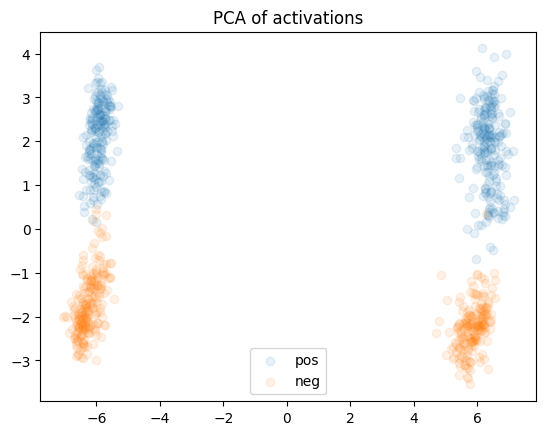

In [17]:
plt.scatter(projected_activations[:len(pos), 0], projected_activations[:len(pos), 1], alpha=0.1, label="pos")
plt.scatter(projected_activations[len(pos):, 0], projected_activations[len(pos):, 1], alpha=0.1, label="neg")
plt.legend()
plt.title("PCA of activations")
plt.show()

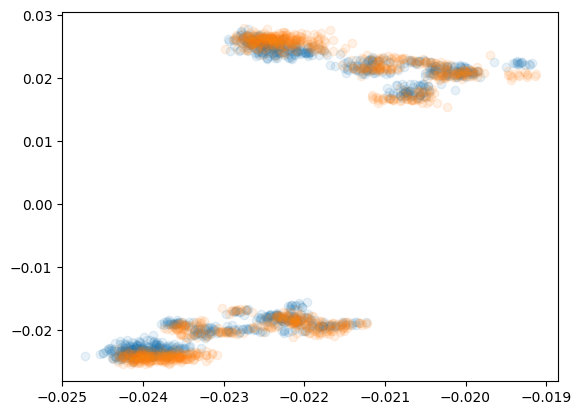

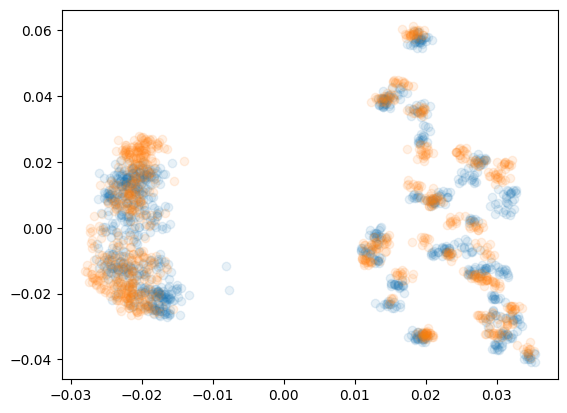

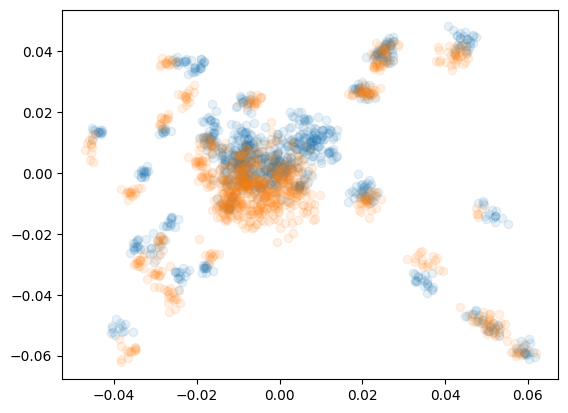

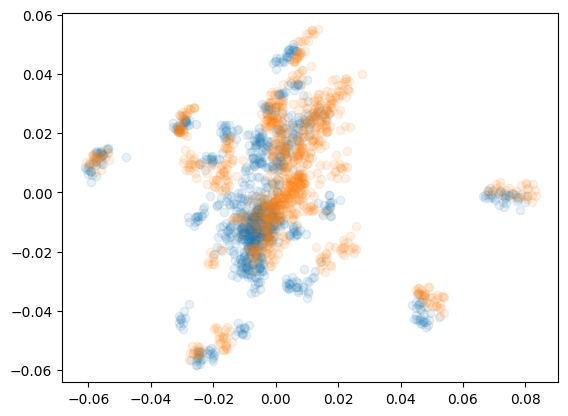

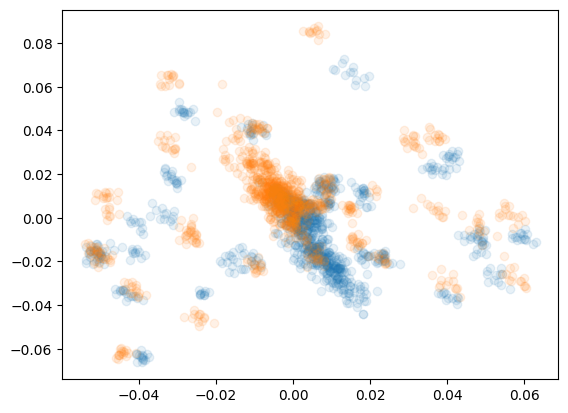

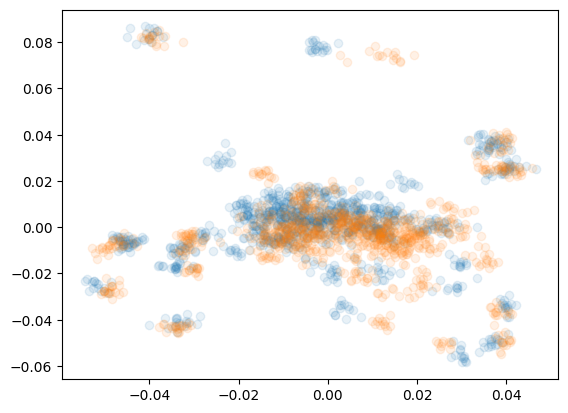

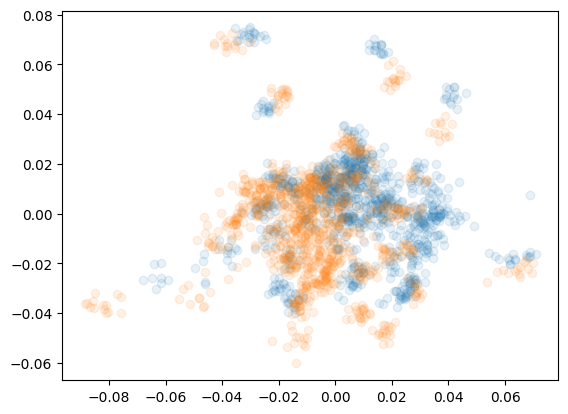

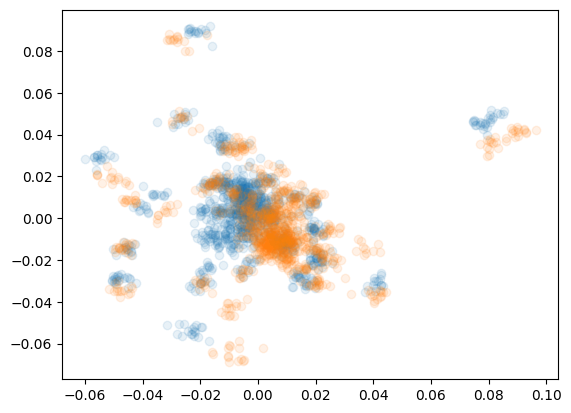

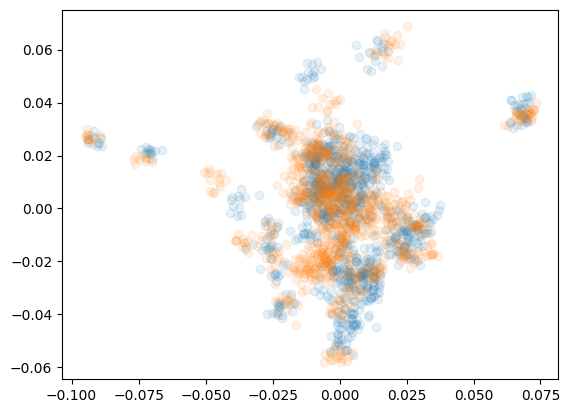

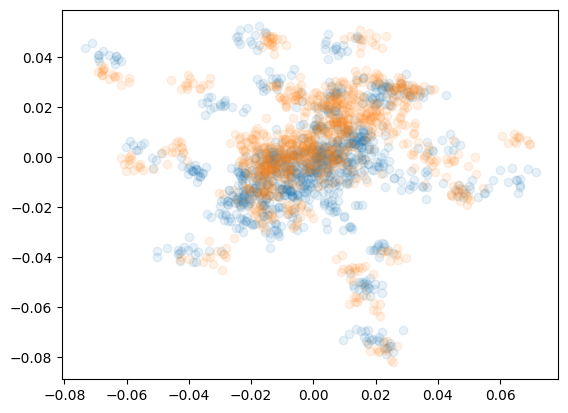

In [10]:
for i in range(0, 20, 2):
    j = i+1
    plt.scatter(-U[:1000, i], -U[:1000, j], alpha=0.1)
    plt.scatter(-U[1000:, i], -U[1000:, j], alpha=0.1)
    plt.show()